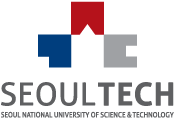

# Lab Session \# 02
---

by Prof. Josué Obregón <br>
Data Analysis for Electronic Manufacturing <br>
Department of Data Science - SeoulTech<br>

## Objective

The objectives of this lab session are as follows:

1.   Introduce additional Pandas functions useful for data manipulation and exploration
2.   To introduce Pandas ability to create simple plots that are useful for data visualization

# Combining Datasets: concat and append

Some of the most interesting studies of data come from combining different data sources.
These operations can involve anything from very straightforward concatenation of two different datasets to more complicated database-style joins and merges that correctly handle any overlaps between the datasets.
`Series` and ``DataFrame``s are built with this type of operation in mind, and Pandas includes functions and methods that make this sort of data wrangling fast and straightforward.

Here we'll take a look at simple concatenation of `Series` and ``DataFrame``s with the `pd.concat` function in Pandas.

We begin with the standard imports:

In [1]:
import pandas as pd
import numpy as np

For convenience, we'll define this function, which creates a `DataFrame` of a particular form that will be useful in the following examples:

In [ ]:
def make_df(cols, ind):
    """Quickly make a DataFrame"""
    data = {c: [str(c) + str(i) for i in ind]
            for c in cols}
    return pd.DataFrame(data, ind)

# example DataFrame
make_df('ABC', range(3))

,A,B,C
0,A0,B0,C0
1,A1,B1,C1
2,A2,B2,C2


In addition, we'll create a quick class that allows us to display multiple ``DataFrame``s side by side. The code makes use of the special `_repr_html_` method, which IPython/Jupyter uses to implement its rich object display:

In [ ]:
class display(object):
    """Display HTML representation of multiple objects"""
    template = """<div style="float: left; padding: 10px;">
    <p style='font-family:"Courier New", Courier, monospace'>{0}</p>{1}
    </div>"""
    def __init__(self, *args):
        self.args = args

    def _repr_html_(self):
        return '\n'.join(self.template.format(a, eval(a)._repr_html_())
                         for a in self.args)

    def __repr__(self):
        return '\n\n'.join(a + '\n' + repr(eval(a))
                           for a in self.args)

The use of this will become clearer as we continue our discussion in the following section.

## Recall: Concatenation of NumPy Arrays

Concatenation of `Series` and `DataFrame` objects behaves similarly to concatenation of NumPy arrays, which can be done via the `np.concatenate` function.
Recall that with it, you can combine the contents of two or more arrays into a single array:

In [ ]:
np.concatenate? # Join a sequence of arrays along an existing axis.

In [ ]:
x = [1, 2, 3]
y = [4, 5, 6]
z = [7, 8, 9]

#concatenate x, y and z
np.concatenate([x, y, z], axis=0)

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

In [ ]:
np.stack([x, y, z]).shape

(3, 3)

The first argument is a list or tuple of arrays to concatenate.
Additionally, in the case of multidimensional arrays, it takes an `axis` keyword that allows you to specify the axis along which the result will be concatenated:

In [ ]:
x = [[1, 2],
     [3, 4]]

#concatenate x and x
np.concatenate([x, x], axis=1)

array([[1, 2, 1, 2],
       [3, 4, 3, 4]])

## Simple Concatenation with pd.concat

The `pd.concat` function provides a similar syntax to `np.concatenate` but contains a number of options that we'll discuss momentarily:

```python
# Signature in Pandas v1.3.5
pd.concat(objs, axis=0, join='outer', ignore_index=False, keys=None,
          levels=None, names=None, verify_integrity=False,
          sort=False, copy=True)
```

`pd.concat` can be used for a simple concatenation of `Series` or `DataFrame` objects, just as `np.concatenate` can be used for simple concatenations of arrays:

In [ ]:
ser1 = pd.Series(['A', 'B', 'C'], index=[1, 2, 3])
ser2 = pd.Series(['D', 'E', 'F'], index=[4, 5, 6])

#concatenate ser1 and ser2
pd.concat([ser1, ser2], axis=1)

,0,1
1,A,NaN
2,B,NaN
3,C,NaN
4,NaN,D
5,NaN,E
6,NaN,F


It also works to concatenate higher-dimensional objects, such as ``DataFrame``s:

In [ ]:
df1 = make_df('AB', [1, 2])
df2 = make_df('AB', [3, 4])
#display('df1', 'df2', 'pd.concat([df1, df2])')

concat_df = pd.concat([df1, df2])
display('df1', 'df2', 'concat_df')

,A,B
1,A1,B1
2,A2,B2
,A,B
3,A3,B3
4,A4,B4
,A,B
1,A1,B1
2,A2,B2
3,A3,B3
4,A4,B4


It's default behavior is to concatenate row-wise within the `DataFrame` (i.e., `axis=0`).
Like `np.concatenate`, `pd.concat` allows specification of an axis along which concatenation will take place.
Consider the following example:

In [ ]:
df3 = make_df('AB', [0, 1])
df4 = make_df('CD', [0, 1])
display('df3', 'df4', "pd.concat([df3, df4], axis='columns')")

df3
    A   B
0  A0  B0
1  A1  B1

df4
    C   D
0  C0  D0
1  C1  D1

pd.concat([df3, df4], axis='columns')
    A   B   C   D
0  A0  B0  C0  D0
1  A1  B1  C1  D1

We could have equivalently specified ``axis=1``; here we've used the more intuitive ``axis='columns'``.

### Duplicate Indices

One important difference between `np.concatenate` and `pd.concat` is that Pandas concatenation *preserves indices*, even if the result will have duplicate indices!
Consider this short example:

In [ ]:
x = make_df('AB', [0, 1])
y = make_df('AB', [2, 3])
y.index = x.index  # make indices match
display('x', 'y', 'pd.concat([x, y])')

,A,B
0,A0,B0
1,A1,B1
,A,B
0,A2,B2
1,A3,B3
,A,B
0,A0,B0
1,A1,B1
0,A2,B2
1,A3,B3


Notice the repeated indices in the result.
While this is valid within ``DataFrame``s, the outcome is often undesirable.
`pd.concat` gives us a few ways to handle it.

#### Treating repeated indices as an error

If you'd like to simply verify that the indices in the result of `pd.concat` do not overlap, you can include the `verify_integrity` flag.
With this set to `True`, the concatenation will raise an exception if there are duplicate indices.
Here is an example, where for clarity we'll catch and print the error message:

In [ ]:
try:
    #concatenate x and y DataFrames while verifying integrity
    pd.concat([x, y], verify_integrity=True)
except ValueError as e:
    print("ValueError:", e)

ValueError: Indexes have overlapping values: Index([0, 1], dtype='int64')


#### Ignoring the index

Sometimes the index itself does not matter, and you would prefer it to simply be ignored.
This option can be specified using the `ignore_index` flag.
With this set to `True`, the concatenation will create a new integer index for the resulting `DataFrame`:

In [ ]:
#concatenate x and y DataFrames while ignoring the index
pd.concat([x, y], ignore_index=True)
display('x', 'y', 'concat_df')

,A,B
0,A0,B0
1,A1,B1
,A,B
0,A2,B2
1,A3,B3
,A,B
1,A1,B1
2,A2,B2
3,A3,B3
4,A4,B4


### Concatenation with Joins

In the short examples we just looked at, we were mainly concatenating ``DataFrame``s with shared column names.
In practice, data from different sources might have different sets of column names, and `pd.concat` offers several options in this case.
Consider the concatenation of the following two ``DataFrame``s, which have some (but not all!) columns in common:

In [ ]:
df5 = make_df('ABC', [1, 2])
df6 = make_df('BCD', [3, 4])
display('df5', 'df6', 'pd.concat([df5, df6])')

df5
    A   B   C
1  A1  B1  C1
2  A2  B2  C2

df6
    B   C   D
3  B3  C3  D3
4  B4  C4  D4

pd.concat([df5, df6])
     A   B   C    D
1   A1  B1  C1  NaN
2   A2  B2  C2  NaN
3  NaN  B3  C3   D3
4  NaN  B4  C4   D4

The default behavior is to fill entries for which no data is available with NA values.
To change this, we can adjust the `join` parameter of the `concat` function.
By default, the join is a union of the input columns (`join='outer'`), but we can change this to an intersection of the columns using `join='inner'`:

* outer: union
* inner: intersection

In [ ]:
pd.concat([df5, df6], join="inner")

,B,C
1,B1,C1
2,B2,C2
3,B3,C3
4,B4,C4


In [ ]:
pd.concat([df5, df6], join="inner", axis='columns') # 공통되는 column값 없으므로 null

,A,B,C,B,C,D


In [ ]:
pd.concat([df5, df6], join="outer", axis='columns')

,A,B,C,B,C,D
1,A1,B1,C1,NaN,NaN,NaN
2,A2,B2,C2,NaN,NaN,NaN
3,NaN,NaN,NaN,B3,C3,D3
4,NaN,NaN,NaN,B4,C4,D4


# Aggregation and Grouping

A fundamental piece of many data analysis tasks is efficient summarization: computing aggregations like `sum`, `mean`, `median`, `min`, and `max`, in which a single number summarizes aspects of a potentially large dataset.
In this chapter, we'll explore aggregations in Pandas, from simple operations akin to what we've seen on NumPy arrays to more sophisticated operations based on the concept of a `groupby`.

## Planets Data

Here we will use the Planets dataset, available via the [Seaborn package](http://seaborn.pydata.org/).
It gives information on planets that astronomers have discovered around other stars (known as *extrasolar planets*, or *exoplanets* for short). It can be downloaded with a simple Seaborn command:

In [3]:
import seaborn as sns
planets = sns.load_dataset('planets')
planets.shape

(1035, 6)

In [ ]:
planets.head()

,method,number,orbital_period,mass,distance,year
0,Radial Velocity,1,269.300,7.10,77.40,2006
1,Radial Velocity,1,874.774,2.21,56.95,2008
2,Radial Velocity,1,763.000,2.60,19.84,2011
3,Radial Velocity,1,326.030,19.40,110.62,2007
4,Radial Velocity,1,516.220,10.50,119.47,2009


This has some details on the 1,000+ extrasolar planets discovered up to 2014.

## Simple Aggregation in Pandas

Before, we have explored some of the data aggregations available for NumPy arrays.
As with a one-dimensional NumPy array, for a Pandas ``Series`` the aggregates return a single value:

In [ ]:
rng = np.random.RandomState(42)
ser = pd.Series(rng.rand(5))
ser

,0
0,0.374540
1,0.950714
2,0.731994
3,0.598658
4,0.156019


In [ ]:
ser.sum()

2.811925491708157

In [ ]:
ser.mean()

0.5623850983416314

In [ ]:
ser.var()

0.09532548164256274

In [ ]:
ser.min()

0.15601864044243652

For a `DataFrame`, by default the aggregates return results within each column:

In [ ]:
df = pd.DataFrame({'A': rng.rand(5),
                   'B': rng.rand(5)})
df

,A,B
0,0.155995,0.020584
1,0.058084,0.969910
2,0.866176,0.832443
3,0.601115,0.212339
4,0.708073,0.181825


In [ ]:
df.mean()

,0
A,0.477888
B,0.443420


By specifying the `axis` argument, you can instead aggregate within each row:

In [ ]:
df.mean(axis='columns')

,0
0,0.088290
1,0.513997
2,0.849309
3,0.406727
4,0.444949


Pandas `Series` and `DataFrame` objects include all of the common aggregates mentioned before (min, max, sum, prod, var, median, etc); in addition, there is a convenience method, `describe`, that computes several common aggregates for each column and returns the result.
Let's use this on the Planets data, for now dropping rows with missing values:

In [ ]:
planets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1035 entries, 0 to 1034
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   method          1035 non-null   object 
 1   number          1035 non-null   int64  
 2   orbital_period  992 non-null    float64
 3   mass            513 non-null    float64
 4   distance        808 non-null    float64
 5   year            1035 non-null   int64  
dtypes: float64(3), int64(2), object(1)
memory usage: 48.6+ KB


In [ ]:
planets.describe()

,number,orbital_period,mass,distance,year
count,1035.000000,992.000000,513.000000,808.000000,1035.000000
mean,1.785507,2002.917596,2.638161,264.069282,2009.070531
std,1.240976,26014.728304,3.818617,733.116493,3.972567
min,1.000000,0.090706,0.003600,1.350000,1989.000000
25%,1.000000,5.442540,0.229000,32.560000,2007.000000
50%,1.000000,39.979500,1.260000,55.250000,2010.000000
75%,2.000000,526.005000,3.040000,178.500000,2012.000000
max,7.000000,730000.000000,25.000000,8500.000000,2014.000000


In [ ]:
planets.dropna().describe()

,number,orbital_period,mass,distance,year
count,498.00000,498.000000,498.000000,498.000000,498.000000
mean,1.73494,835.778671,2.509320,52.068213,2007.377510
std,1.17572,1469.128259,3.636274,46.596041,4.167284
min,1.00000,1.328300,0.003600,1.350000,1989.000000
25%,1.00000,38.272250,0.212500,24.497500,2005.000000
50%,1.00000,357.000000,1.245000,39.940000,2009.000000
75%,2.00000,999.600000,2.867500,59.332500,2011.000000
max,6.00000,17337.500000,25.000000,354.000000,2014.000000


This method helps us understand the overall properties of a dataset.
For example, we see in the `year` column that although exoplanets were discovered as far back as 1989, half of all planets in the dataset were not discovered until 2010 or after.
This is largely thanks to the *Kepler* mission, which aimed to find eclipsing planets around other stars using a specially designed space telescope.

The following table summarizes some other built-in Pandas aggregations:

| Aggregation              | Returns                         |
|--------------------------|---------------------------------|
| ``count``                | Total number of items           |
| ``first``, ``last``      | First and last item             |
| ``mean``, ``median``     | Mean and median                 |
| ``min``, ``max``         | Minimum and maximum             |
| ``std``, ``var``         | Standard deviation and variance |
| ``mad``                  | Mean absolute deviation         |
| ``prod``                 | Product of all items            |
| ``sum``                  | Sum of all items                |

These are all methods of `DataFrame` and `Series` objects.

Let's explore some of those functions!

To go deeper into the data, however, simple aggregates are often not enough.
The next level of data summarization is the `groupby` operation, which allows you to quickly and efficiently compute aggregates on subsets of data.

## groupby: Split, Apply, Combine

Simple aggregations can give you a flavor of your dataset, but often we would prefer to aggregate conditionally on some label or index: this is implemented in the so-called `groupby` operation.
The name "group by" comes from a command in the SQL database language, but it is perhaps more illuminative to think of it in the terms first coined by Hadley Wickham of Rstats fame: *split, apply, combine*.

### Split, Apply, Combine

A canonical example of this split-apply-combine operation, where the "apply" is a summation aggregation, is illustrated in this figure:

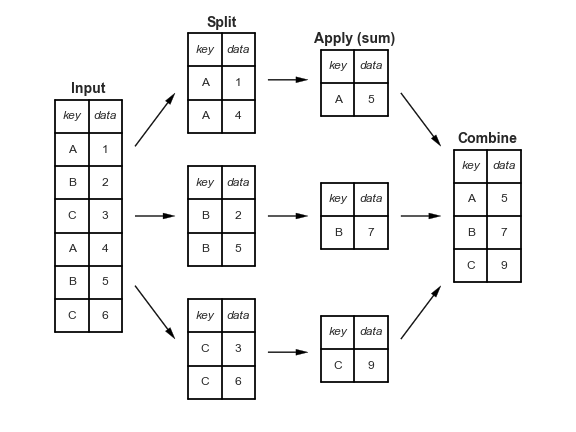

This illustrates what the `groupby` operation accomplishes:

- The *split* step involves breaking up and grouping a `DataFrame` depending on the value of the specified key.
- The *apply* step involves computing some function, usually an aggregate, transformation, or filtering, within the individual groups.
- The *combine* step merges the results of these operations into an output array.

While this could certainly be done manually using some combination of the masking, aggregation, and merging commands covered earlier, an important realization is that *the intermediate splits do not need to be explicitly instantiated*. Rather, the `groupby` can (often) do this in a single pass over the data, updating the sum, mean, count, min, or other aggregate for each group along the way.
The power of the `groupby` is that it abstracts away these steps: the user need not think about *how* the computation is done under the hood, but rather can think about the *operation as a whole*.

As a concrete example, let's take a look at using Pandas for the computation shown in the following figure.
We'll start by creating the input `DataFrame`:

In [ ]:
df = pd.DataFrame({'key': ['A', 'B', 'C', 'A', 'B', 'C'],
                   'data': range(6)}, columns=['key', 'data'])
df

,key,data
0,A,0
1,B,1
2,C,2
3,A,3
4,B,4
5,C,5


The most basic split-apply-combine operation can be computed with the `groupby` method of the `DataFrame`, passing the name of the desired key column:

In [ ]:
df.groupby('key')

Notice that what is returned is a `DataFrameGroupBy` object, not a set of `DataFrame` objects.
This object is where the magic is: you can think of it as a special view of the `DataFrame`, which is poised to dig into the groups but does no actual computation until the aggregation is applied.
This "lazy evaluation" approach means that common aggregates can be implemented efficiently in a way that is almost transparent to the user.

To produce a result, we can apply an aggregate to this `DataFrameGroupBy` object, which will perform the appropriate apply/combine steps to produce the desired result:

In [ ]:
df.groupby('key').sum()

,data
key,
A,3
B,5
C,7


In [ ]:
df.groupby('key').std()

,data
key,
A,2.12132
B,2.12132
C,2.12132


In [ ]:
df.groupby('key').max()

,data
key,
A,3
B,4
C,5


The `sum` method is just one possibility here; you can apply most Pandas or NumPy aggregation functions, as well as most `DataFrame` operations, as you will see in the following discussion.

### The GroupBy Object

The `GroupBy` object is a flexible abstraction: in many ways, it can be treated as simply a collection of ``DataFrame``s, though it is doing more sophisticated things under the hood. Let's see some examples using the Planets data.

Perhaps the most important operations made available by a `GroupBy` are *aggregate*, *filter*, *transform*, and *apply*.
We'll discuss each of these more fully in the next section, but before that let's take a look at some of the other functionality that can be used with the basic `GroupBy` operation.

#### Column indexing

The `GroupBy` object supports column indexing in the same way as the `DataFrame`, and returns a modified `GroupBy` object.
For example:

In [ ]:
planets.head(3)

,method,number,orbital_period,mass,distance,year
0,Radial Velocity,1,269.300,7.10,77.40,2006
1,Radial Velocity,1,874.774,2.21,56.95,2008
2,Radial Velocity,1,763.000,2.60,19.84,2011


In [ ]:
planets['method'].unique()

array(['Radial Velocity', 'Imaging', 'Eclipse Timing Variations',
       'Transit', 'Astrometry', 'Transit Timing Variations',
       'Orbital Brightness Modulation', 'Microlensing', 'Pulsar Timing',
       'Pulsation Timing Variations'], dtype=object)

In [ ]:
planets.groupby('method')['orbital_period'].median()

,orbital_period
method,
Astrometry,631.180000
Eclipse Timing Variations,4343.500000
Imaging,27500.000000
Microlensing,3300.000000
Orbital Brightness Modulation,0.342887
Pulsar Timing,66.541900
Pulsation Timing Variations,1170.000000
Radial Velocity,360.200000
Transit,5.714932


Here we've selected a particular `Series` group from the original `DataFrame` group by reference to its column name.
As with the `GroupBy` object, no computation is done until we call some aggregate on the object:

This gives an idea of the general scale of orbital periods (in days) that each method is sensitive to.

#### Iteration over groups

The `GroupBy` object supports direct iteration over the groups, returning each group as a `Series` or `DataFrame`:

In [ ]:
for method, group in planets.groupby('method'):
    print("{0:30s} shape={1}".format(method, group.shape))

Astrometry                     shape=(2, 6)
Eclipse Timing Variations      shape=(9, 6)
Imaging                        shape=(38, 6)
Microlensing                   shape=(23, 6)
Orbital Brightness Modulation  shape=(3, 6)
Pulsar Timing                  shape=(5, 6)
Pulsation Timing Variations    shape=(1, 6)
Radial Velocity                shape=(553, 6)
Transit                        shape=(397, 6)
Transit Timing Variations      shape=(4, 6)


This can be useful for manual inspection of groups for the sake of debugging, but it is often much faster to use the built-in `apply` functionality, which we will discuss momentarily.

### Aggregate, Filter, Transform, Apply

The preceding discussion focused on aggregation for the combine operation, but there are more options available.
In particular, `GroupBy` objects have `aggregate`, `filter`, `transform`, and `apply` methods that efficiently implement a variety of useful operations before combining the grouped data.

For the purpose of the following subsections, we'll use this ``DataFrame``:

In [ ]:
rng = np.random.RandomState(0)
df = pd.DataFrame({'key': ['A', 'B', 'C', 'A', 'B', 'C'],
                   'data1': range(6),
                   'data2': rng.randint(0, 10, 6)},
                   columns = ['key', 'data1', 'data2'])
df

,key,data1,data2
0,A,0,5
1,B,1,0
2,C,2,3
3,A,3,3
4,B,4,7
5,C,5,9


#### Aggregation

You're now familiar with `GroupBy` aggregations with `sum`, `median`, and the like, but the `aggregate` method allows for even more flexibility.
It can take a string, a function, or a list thereof, and compute all the aggregates at once.
Here is a quick example combining all of these:

In [ ]:
df.groupby('key').aggregate(['min', np.median, max])

<ipython-input-62-1925fa6293f4>:1: FutureWarning: The provided callable <function median at 0x7b0c4634f910> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  df.groupby('key').aggregate(['min', np.median, max])
<ipython-input-62-1925fa6293f4>:1: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  df.groupby('key').aggregate(['min', np.median, max])


data1            data2           
      min median max   min median max
key                                  
A       0    1.5   3     3    4.0   5
B       1    2.5   4     0    3.5   7
C       2    3.5   5     3    6.0   9

In [ ]:
df.groupby('key')['data1'].aggregate(['min', np.median, max])

<ipython-input-61-cc00551edbd6>:1: FutureWarning: The provided callable <function median at 0x7b0c4634f910> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  df.groupby('key')['data1'].aggregate(['min', np.median, max])
<ipython-input-61-cc00551edbd6>:1: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  df.groupby('key')['data1'].aggregate(['min', np.median, max])


,min,median,max
key,,,
A,0,1.5,3
B,1,2.5,4
C,2,3.5,5


Another common pattern is to pass a dictionary mapping column names to operations to be applied on that column:

In [ ]:
df.groupby('key').aggregate({'data1': 'min',
                             'data2': ['max', 'mean', np.median]})

<ipython-input-65-d2576d622e84>:1: FutureWarning: The provided callable <function median at 0x7b0c4634f910> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  df.groupby('key').aggregate({'data1': 'min',


data1 data2            
      min   max mean median
key                        
A       0     5  4.0    4.0
B       1     7  3.5    3.5
C       2     9  6.0    6.0

#### Filtering

A filtering operation allows you to drop data based on the group properties.
For example, we might want to keep all groups in which the standard deviation is larger than some critical value:

In [ ]:
def filter_func(x):
    return x['data2'].std() > 4

In [ ]:
df_groupby = df.groupby('key').std()
df_groupby

,data1,data2
key,,
A,2.12132,1.414214
B,2.12132,4.949747
C,2.12132,4.242641


In [ ]:
df_filter = df.groupby('key').filter(filter_func)
df_filter

,key,data1,data2
1,B,1,0
2,C,2,3
4,B,4,7
5,C,5,9


The filter function should return a Boolean value specifying whether the group passes the filtering. Here, because group A does not have a standard deviation greater than 4, it is dropped from the result.

#### Transformation

While aggregation must return a reduced version of the data, transformation can return some transformed version of the full data to recombine.
For such a transformation, the output is the same shape as the input.
A common example is to center the data by subtracting the group-wise mean:

In [ ]:
def center(x):
    return x - x.mean()

In [ ]:
df

,key,data1,data2
0,A,0,5
1,B,1,0
2,C,2,3
3,A,3,3
4,B,4,7
5,C,5,9


In [ ]:
df.groupby('key').transform(center)

,data1,data2
0,-1.5,1.0
1,-1.5,-3.5
2,-1.5,-3.0
3,1.5,-1.0
4,1.5,3.5
5,1.5,3.0


In [ ]:
df.groupby('key').transform(center).mean()

,0
data1,0.0
data2,0.0


#### The apply method

The `apply` method lets you apply an arbitrary function to the group results.
The function should take a `DataFrame` and returns either a Pandas object (e.g., `DataFrame`, `Series`) or a scalar; the behavior of the combine step will be tailored to the type of output returned.

For example, here is an `apply` operation that normalizes the first column by the sum of the second:

In [ ]:
def norm_by_data2(x):
    # x is a DataFrame of group values
    x['data1'] /= x['data2'].sum()
    return x

In [ ]:
df.groupby('key', group_keys=False).apply(norm_by_data2)

<ipython-input-77-e4373bbb4791>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby('key', group_keys=False).apply(norm_by_data2)


,key,data1,data2
0,A,0.000000,5
1,B,0.142857,0
2,C,0.166667,3
3,A,0.375000,3
4,B,0.571429,7
5,C,0.416667,9


`apply` within a `GroupBy` is flexible: the only criterion is that the function takes a `DataFrame` and returns a Pandas object or scalar. What you do in between is up to you!

### Specifying the Split Key

In the simple examples presented before, we split the `DataFrame` on a single column name.
This is just one of many options by which the groups can be defined, and we'll go through some other options for group specification here.

#### A list, array, series, or index providing the grouping keys

The key can be any series or list with a length matching that of the `DataFrame`. For example:

In [ ]:
L = [0, 1, 0, 1, 2, 0]
L

[0, 1, 0, 1, 2, 0]

In [ ]:
df.groupby(L).sum()

,key,data1,data2
0,ACC,7,17
1,BA,4,3
2,B,4,7


Of course, this means there's another, more verbose way of accomplishing the `df.groupby('key')` from before:

In [ ]:
df.groupby(df['key']).sum()

,data1,data2
key,,
A,3,8
B,5,7
C,7,12


#### A dictionary or series mapping index to group

Another method is to provide a dictionary that maps index values to the group keys:

In [ ]:
df

,key,data1,data2
0,A,0,5
1,B,1,0
2,C,2,3
3,A,3,3
4,B,4,7
5,C,5,9


In [ ]:
df2 = df.set_index('key')
df2

,data1,data2
key,,
A,0,5
B,1,0
C,2,3
A,3,3
B,4,7
C,5,9


In [ ]:
mapping = {'A': 'vowel', 'B': 'consonant', 'C': 'consonant'}
df2.groupby(mapping).mean()

,data1,data2
key,,
consonant,3.0,4.75
vowel,1.5,4.00


#### Any Python function

Similar to mapping, you can pass any Python function that will input the index value and output the group:

#### A list of valid keys

Further, any of the preceding key choices can be combined to group on a multi-index:

### Grouping Example

As an example of this, let's find the count of discovered planets by method and by decade:

In [ ]:
decade = 10 * (planets['year'] // 10)


This shows the power of combining many of the operations we've discussed up to this point when looking at realistic datasets: we quickly gain a coarse understanding of when and how extrasolar planets were detected in the years after the first discovery.

I would suggest digging into these few lines of code and evaluating the individual steps to make sure you understand exactly what they are doing to the result.
It's certainly a somewhat complicated example, but understanding these pieces will give you the means to similarly explore your own data.

# Pivot Tables

We have seen how the `groupby` abstraction lets us explore relationships within a dataset.
A *pivot table* is a similar operation that is commonly seen in spreadsheets and other programs that operate on tabular data.
The pivot table takes simple column-wise data as input, and groups the entries into a two-dimensional table that provides a multidimensional summarization of the data.
The difference between pivot tables and `groupby` can sometimes cause confusion; it helps me to think of pivot tables as essentially a *multidimensional* version of `groupby` aggregation.
That is, you split-apply-combine, but both the split and the combine happen across not a one-dimensional index, but across a two-dimensional grid.

## Motivating Pivot Tables

For the examples in this section, we'll use the database of passengers on the *Titanic*, available through the Seaborn library.

In [4]:
titanic = sns.load_dataset('titanic')

In [5]:
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [7]:
titanic.shape

(891, 15)

As the output shows, this contains a number of data points on each passenger on that ill-fated voyage, including sex, age, class, fare paid, and much more.

## Pivot Tables by Hand

To start learning more about this data, we might begin by grouping according to sex, survival status, or some combination thereof.
If you read the previous chapter, you might be tempted to apply a `groupby` operation—for example, let's look at survival rate by sex:

In [9]:
titanic.groupby('sex')[['survived']].mean()

,survived
sex,
female,0.742038
male,0.188908


This gives us some initial insight: overall, three of every four females on board survived, while only one in five males survived!

This is useful, but we might like to go one step deeper and look at survival rates by both sex and, say, class.
Using the vocabulary of `groupby`, we might proceed using a process like this:
we first *group by* class and sex, then *select* survival, *apply* a mean aggregate, *combine* the resulting groups, and finally *unstack* the hierarchical index to reveal the hidden multidimensionality. In code:

In [21]:
titanic.groupby(['sex', 'class'])['survived'].aggregate('mean')

<ipython-input-21-1c9519f5771b>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  titanic.groupby(['sex', 'class'])['survived'].aggregate('mean')


sex     class 
female  First     0.968085
        Second    0.921053
        Third     0.500000
male    First     0.368852
        Second    0.157407
        Third     0.135447
Name: survived, dtype: float64

In [14]:
titanic.groupby(['sex', 'class'])['survived'].aggregate('mean').unstack()

<ipython-input-14-45061042d882>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  titanic.groupby(['sex', 'class'])['survived'].aggregate('mean').unstack()


class,First,Second,Third
sex,,,
female,0.968085,0.921053,0.500000
male,0.368852,0.157407,0.135447


This gives us a better idea of how both sex and class affected survival, but the code is starting to look a bit garbled.
While each step of this pipeline makes sense in light of the tools we've previously discussed, the long string of code is not particularly easy to read or use.
This two-dimensional `groupby` is common enough that Pandas includes a convenience routine, `pivot_table`, which succinctly handles this type of multidimensional aggregation.

## Pivot Table Syntax

Here is the equivalent to the preceding operation using the `DataFrame.pivot_table` method:

In [15]:
titanic.pivot_table?

In [16]:
titanic.head(2)

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False


In [17]:
titanic.pivot_table('survived', index='sex', columns='class', aggfunc='mean')

<ipython-input-17-d1df76ca0a66>:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  titanic.pivot_table('survived', index='sex', columns='class', aggfunc='mean')


class,First,Second,Third
sex,,,
female,0.968085,0.921053,0.500000
male,0.368852,0.157407,0.135447


In [18]:
titanic.pivot_table('survived', index='sex', columns='class', aggfunc='count')

<ipython-input-18-5582d331718e>:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  titanic.pivot_table('survived', index='sex', columns='class', aggfunc='count')


class,First,Second,Third
sex,,,
female,94,76,144
male,122,108,347


In [19]:
titanic.pivot_table('survived', index='sex', columns='class', aggfunc='sum')

<ipython-input-19-295ddef55151>:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  titanic.pivot_table('survived', index='sex', columns='class', aggfunc='sum')


class,First,Second,Third
sex,,,
female,91,70,72
male,45,17,47


This is eminently more readable than the manual `groupby` approach, and produces the same result.
As you might expect of an early 20th-century transatlantic cruise, the survival gradient favors both higher classes and people recorded as females in the
data. First-class females survived with near certainty (hi, Rose!), while only one in eight or so third-class males survived (sorry, Jack!).

### Multilevel Pivot Tables

Just as in a `groupby`, the grouping in pivot tables can be specified with multiple levels and via a number of options.
For example, we might be interested in looking at age as a third dimension.
We'll bin the age using the `pd.cut` function:

In [20]:
age = pd.cut(titanic['age'], [0, 18, 80])
age

,age
0,"(18.0, 80.0]"
1,"(18.0, 80.0]"
2,"(18.0, 80.0]"
3,"(18.0, 80.0]"
4,"(18.0, 80.0]"
...,...
886,"(18.0, 80.0]"
887,"(18.0, 80.0]"
888,NaN
889,"(18.0, 80.0]"


In [26]:
titanic.pivot_table('survived', index=['sex', age], columns='class', aggfunc='mean')

<ipython-input-26-94b9407bf871>:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  titanic.pivot_table('survived', index=['sex', age], columns='class', aggfunc='mean')


class               First    Second     Third
sex    age                                   
female (0, 18]   0.909091  1.000000  0.511628
       (18, 80]  0.972973  0.900000  0.423729
male   (0, 18]   0.800000  0.600000  0.215686
       (18, 80]  0.375000  0.071429  0.133663

### Additional Pivot Table Options

The full call signature of the `DataFrame.pivot_table` method is as follows:

```python
# call signature as of Pandas 1.3.5
DataFrame.pivot_table(data, values=None, index=None, columns=None,
                      aggfunc='mean', fill_value=None, margins=False,
                      dropna=True, margins_name='All', observed=False,
                      sort=True)
```

We've already seen examples of the first three arguments; here we'll take a quick look at some of the remaining ones.
Two of the options, `fill_value` and `dropna`, have to do with missing data and are fairly straightforward; I will not show examples of them here.

The `aggfunc` keyword controls what type of aggregation is applied, which is a mean by default.
As with `groupby`, the aggregation specification can be a string representing one of several common choices (`'sum'`, `'mean'`, `'count'`, `'min'`, `'max'`, etc.) or a function that implements an aggregation (e.g., `np.sum()`, `min()`, `sum()`, etc.).
Additionally, it can be specified as a dictionary mapping a column to any of the desired options:

In [29]:
titanic.pivot_table(index='sex', columns='class', aggfunc={'survived':sum, 'fare': 'mean' })

<ipython-input-29-00a621eba1af>:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  titanic.pivot_table(index='sex', columns='class', aggfunc={'survived':sum, 'fare': 'mean' })
<ipython-input-29-00a621eba1af>:1: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  titanic.pivot_table(index='sex', columns='class', aggfunc={'survived':sum, 'fare': 'mean' })


fare                       survived             
class        First     Second      Third    First Second Third
sex                                                           
female  106.125798  21.970121  16.118810       91     70    72
male     67.226127  19.741782  12.661633       45     17    47

Notice also here that we've omitted the `values` keyword; when specifying a mapping for `aggfunc`, this is determined automatically.

At times it's useful to compute totals along each grouping.
This can be done via the ``margins`` keyword:

In [30]:
titanic.pivot_table('survived', index='sex', columns='class', aggfunc='mean', margins=True)

<ipython-input-30-228f03a41926>:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  titanic.pivot_table('survived', index='sex', columns='class', aggfunc='mean', margins=True)


class,First,Second,Third,All
sex,,,,
female,0.968085,0.921053,0.500000,0.742038
male,0.368852,0.157407,0.135447,0.188908
All,0.629630,0.472826,0.242363,0.383838


In [31]:
titanic.pivot_table('survived', index='sex', columns='class', aggfunc='mean', margins=False)

<ipython-input-31-d4be0b1b64ed>:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  titanic.pivot_table('survived', index='sex', columns='class', aggfunc='mean', margins=False)


class,First,Second,Third
sex,,,
female,0.968085,0.921053,0.500000
male,0.368852,0.157407,0.135447


Here, this automatically gives us information about the class-agnostic survival rate by sex, the sex-agnostic survival rate by class, and the overall survival rate of 38%.
The margin label can be specified with the `margins_name` keyword; it defaults to `"All"`.

## Example: Birthrate Data

As another example, let's take a look at the freely available data on births in the United States, provided by the Centers for Disease Control (CDC).
This data can be found at https://raw.githubusercontent.com/jakevdp/data-CDCbirths/master/births.csv
(this dataset has been analyzed rather extensively by Andrew Gelman and his group; see, for example, the [blog post on signal processing using Gaussian processes](http://andrewgelman.com/2012/06/14/cool-ass-signal-processing-using-gaussian-processes/)):

[^1]: The CDC dataset used in this section uses the sex assigned at birth, which it calls "gender," and limits the data to male and female. While gender is a spectrum independent of biology, I will be using the same terminology while discussing this dataset for consistency and clarity.

In [32]:
# shell command to download the data:
!cd sample_data && curl -O \
https://raw.githubusercontent.com/jakevdp/data-CDCbirths/master/births.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  258k  100  258k    0     0   969k      0 --:--:-- --:--:-- --:--:--  971k


In [33]:
births = pd.read_csv('sample_data/births.csv')

Taking a look at the data, we see that it's relatively simple—it contains the number of births grouped by date and gender:

In [34]:
births.head()

,year,month,day,gender,births
0,1969,1,1.0,F,4046
1,1969,1,1.0,M,4440
2,1969,1,2.0,F,4454
3,1969,1,2.0,M,4548
4,1969,1,3.0,F,4548


We can start to understand this data a bit more by using a pivot table.
Let's add a `decade` column, and take a look at male and female births as a function of decade:

In [35]:
births['decade'] = 10 * (births['year'] // 10)
births.head()

,year,month,day,gender,births,decade
0,1969,1,1.0,F,4046,1960
1,1969,1,1.0,M,4440,1960
2,1969,1,2.0,F,4454,1960
3,1969,1,2.0,M,4548,1960
4,1969,1,3.0,F,4548,1960


In [36]:
births.pivot_table('births', index='decade', columns='gender', aggfunc='sum')

gender,F,M
decade,,
1960,1753634,1846572
1970,16263075,17121550
1980,18310351,19243452
1990,19479454,20420553
2000,18229309,19106428


We see that male births outnumber female births in every decade.
To see this trend a bit more clearly, we can use the built-in plotting tools in Pandas to visualize the total number of births by year, as shown in the following figure. (We will study more in detail visualization libraries in the following classes):

In [37]:
births.pivot_table('births', columns='decade', index='gender', aggfunc='sum')

decade,1960,1970,1980,1990,2000
gender,,,,,
F,1753634,16263075,18310351,19479454,18229309
M,1846572,17121550,19243452,20420553,19106428


With a simple pivot table and the `plot` method, we can immediately see the annual trend in births by gender. By eye, it appears that over the past 50 years male births have outnumbered female births by around 5%.

<Axes: xlabel='year', ylabel='total births'>

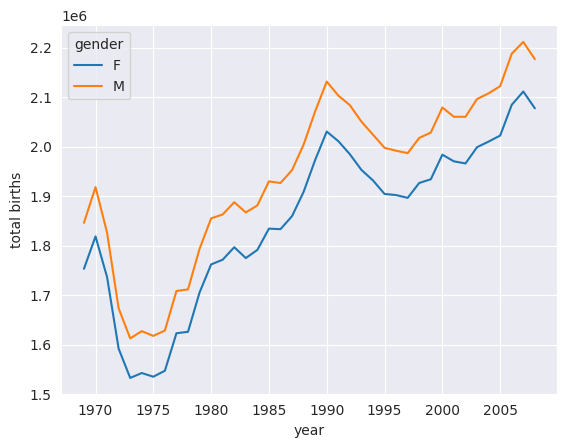

In [41]:
sns.set_style('darkgrid') # others: darkgrid, whitegrid, dark, white, and ticks
births.pivot_table('births', columns='gender', index='year', aggfunc='sum').plot(ylabel='total births')